In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Input, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the MovieLens 10M dataset
columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df = pd.read_csv('/content/drive/MyDrive/data/ml-1m/ratings.dat', sep='::', header=None, names=columns, engine='python')

In [ ]:
df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
# Convert user IDs and item IDs to integers
user_ids = df['UserID'].unique()
user_id_map = {old_id: new_id for new_id, old_id in enumerate(user_ids)}
df['UserID'] = df['UserID'].map(user_id_map)

movie_ids = df['MovieID'].unique()
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(movie_ids)}
df['MovieID'] = df['MovieID'].map(movie_id_map)

In [ ]:
# Split the data into train, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    df[['UserID', 'MovieID']].values,
    df['Rating'].values,
    test_size=0.2,
    random_state=42
)

validation_data, test_data, validation_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    test_size=0.5,
    random_state=42
)

In [ ]:
# Define the input layers
user_input = Input(shape=(1,), dtype='int64', name='user_input')
item_input = Input(shape=(1,), dtype='int64', name='item_input')

# Define the embedding layers
user_embeddings = Embedding(input_dim=len(user_ids), output_dim=64)(user_input)
item_embeddings = Embedding(input_dim=len(movie_ids), output_dim=64)(item_input)

# Concatenate user and item embeddings
embeddings = Concatenate()([user_embeddings, item_embeddings])

# Add hidden layers with activation functions and dropout
hidden_layer1 = Dense(32, activation='relu')(embeddings)
dropout1 = Dropout(0.2)(hidden_layer1)
hidden_layer2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden_layer2)

# Flatten the output before the final prediction layer
flat = Flatten()(dropout2)

# Prediction layer with linear activation function
prediction_layer = Dense(1, activation='linear')(flat)

In [ ]:
# Define the pre-trained NCF model
pre_trained_model = Model(inputs=[user_input, item_input], outputs=prediction_layer)

# Compile the pre-trained model
pre_trained_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
pre_trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 64)                386560    ['user_input[0][0]']          
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 64)                237184    ['item_input[0][0]']          
                                                                                            

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('CF_DL_model_V0.1.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the pre-trained model with validation data and callbacks
history = pre_trained_model.fit(
    {'user_input': train_data[:, 0], 'item_input': train_data[:, 1]},
    train_labels,
    epochs=100,
    validation_data=(
        {'user_input': validation_data[:, 0], 'item_input': validation_data[:, 1]},
        validation_labels
    ),
    callbacks=[early_stopping, model_checkpoint],
    batch_size=1000
)

Epoch 1/100
801/801 [==============================] - 12s 14ms/step - loss: 1.6948 - mae: 0.9729 - val_loss: 0.8519 - val_mae: 0.7363
Epoch 2/100
 11/801 [..............................] - ETA: 8s - loss: 0.9789 - mae: 0.7905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


801/801 [==============================] - 9s 11ms/step - loss: 0.9480 - mae: 0.7749 - val_loss: 0.8231 - val_mae: 0.7199
Epoch 3/100
801/801 [==============================] - 11s 13ms/step - loss: 0.9087 - mae: 0.7573 - val_loss: 0.8113 - val_mae: 0.7146
Epoch 4/100
801/801 [==============================] - 10s 12ms/step - loss: 0.8856 - mae: 0.7466 - val_loss: 0.8056 - val_mae: 0.7134
Epoch 5/100
801/801 [==============================] - 10s 12ms/step - loss: 0.8667 - mae: 0.7384 - val_loss: 0.7970 - val_mae: 0.7077
Epoch 6/100
801/801 [==============================] - 11s 14ms/step - loss: 0.8463 - mae: 0.7291 - val_loss: 0.7918 - val_mae: 0.7061
Epoch 7/100
801/801 [==============================] - 9s 11ms/step - loss: 0.8252 - mae: 0.7194 - val_loss: 0.7862 - val_mae: 0.7008
Epoch 8/100
801/801 [==============================] - 11s 14ms/step - loss: 0.8056 - mae: 0.7100 - val_loss: 0.7816 - val_mae: 0.6990
Epoch 9/100
801/801 [==============================] - 10s 13ms/step 

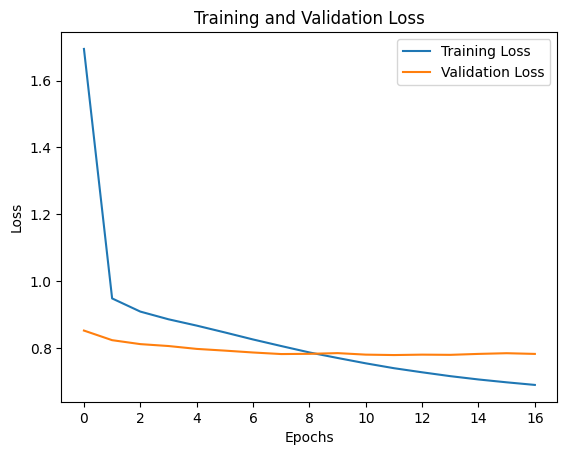

In [ ]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = pre_trained_model.evaluate([test_data[:, 0], test_data[:, 1]], test_labels)
print(f'Test Mean Absolute Error: {test_mae}')

3126/3126 [==============================] - 11s 3ms/step - loss: 0.7834 - mae: 0.6942
Test Mean Absolute Error: 0.694176435470581


In [ ]:
import shutil

file_to_copy = '/content/best_NCF_pre-model.h5'

destination_path = '/content/drive/MyDrive/data/ml-1m'

shutil.copy(file_to_copy, destination_path)


'/content/drive/MyDrive/data/ml-1m/best_NCF_pre-model.h5'